# Parte 1
## Análisis de Sentimientos

### Limpieza de Datos

#### Import and Data Shaping

Primero realizamos los imports necesarios.

In [1]:
import numpy as np 
import pandas as pd
import re 

import matplotlib.pyplot as plt
import seaborn as sns

import os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.stem import SnowballStemmer

import eli5

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

from string import punctuation

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import joblib

Importamos el set de datos de reviews de ropa de mujeres

In [2]:
df = pd.read_csv('../csv/womens_clothing_reviews.csv', encoding='latin-1')
reviews = df.copy()
reviews

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [3]:
df.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [4]:
df.drop(columns=['Unnamed: 0', 'Clothing ID'], inplace=True)
df

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...
23481,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


Para hacer análisis de sentimientos nos resultará útil tener un dataframe únicamente con las reviews mappeadas a sus respectivos ratings.

### Análisis Exploratorio

In [5]:
analyzable = df.dropna(inplace=False)
analyzable

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
...,...,...,...,...,...,...,...,...,...
23481,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      23486 non-null  int64 
 1   Title                    19676 non-null  object
 2   Review Text              22641 non-null  object
 3   Rating                   23486 non-null  int64 
 4   Recommended IND          23486 non-null  int64 
 5   Positive Feedback Count  23486 non-null  int64 
 6   Division Name            23472 non-null  object
 7   Department Name          23472 non-null  object
 8   Class Name               23472 non-null  object
dtypes: int64(4), object(5)
memory usage: 1.6+ MB


A continuación indicamos que representa cada columna del dataframe:

- **Age:** Edad del crítico.
- **Title:** Título de la crítica.
- **Review Text**: Cuerpo de la crítica. 
- **Rating:** Puntuación del producto según el consumidor, siendo 1 la peor y 5 la mejor. 
- **Recommended IND:** Variable binaria donde 1 significa que el consumidor lo recomienda y 0 no.
- **Positive Feedback Count:** Número de otros consumidores que encontraron positiva la crítica.
- **Division Name:** Nombre categórico de la división de alto nivel(más general) del producto.
- **Department Name:** Nombre categórico del departamento del producto.
- **Class Name:** Nombre categórico de la clase del producto.

<AxesSubplot:>

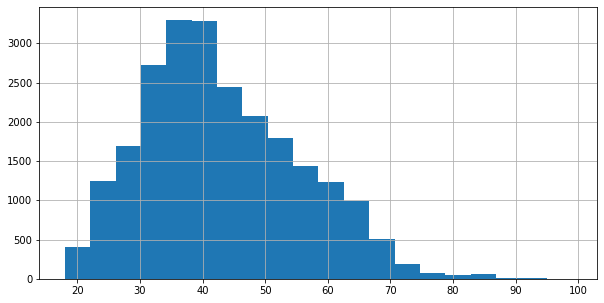

In [7]:
df.Age.hist(bins=20, figsize = (10,5))

[Text(0.5, 1.0, 'Boxplot de la Edad')]

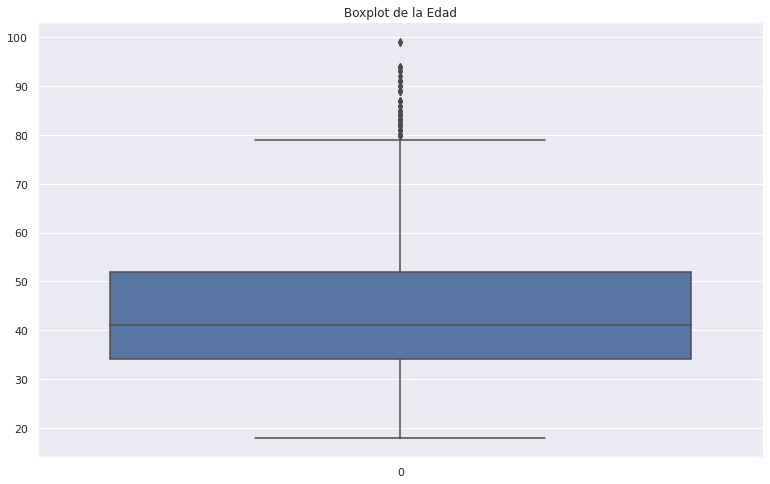

In [8]:
sns.set(rc = {'figure.figsize':(13,8)})
sns.boxplot(data=df.Age).set(title="Boxplot de la Edad")

(3.5, 4.5)

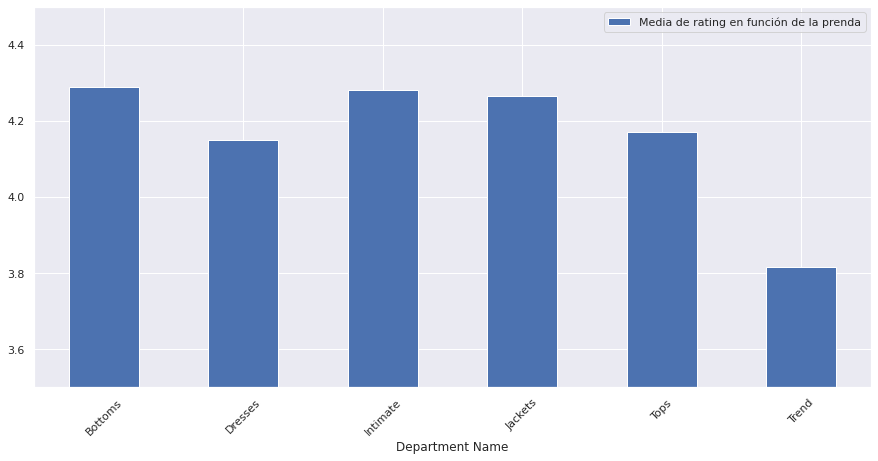

In [9]:
xd = df.groupby("Department Name").agg({'Rating': ['mean']})
xd.plot.bar(figsize = (15,7), rot = 45)
plt.legend(['Media de rating en función de la prenda'])
plt.ylim(3.5, 4.5)

<AxesSubplot:ylabel='Rating'>

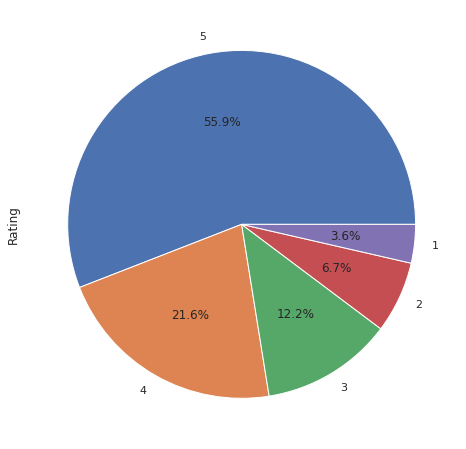

In [10]:
df['Rating'].value_counts().plot.pie(autopct='%1.1f%%')

<AxesSubplot:ylabel='Rating'>

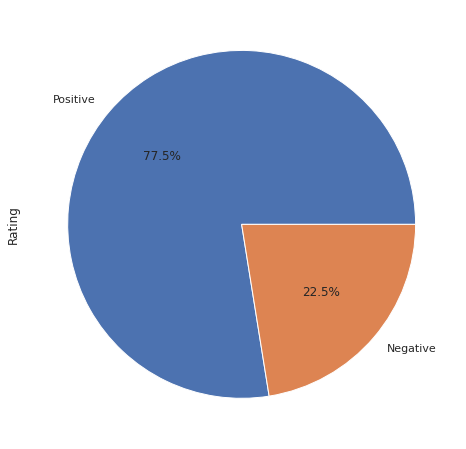

In [11]:
df['Rating'].map(lambda x: 'Positive' if x > 3 else 'Negative').value_counts().plot.pie(autopct='%1.1f%%')

<AxesSubplot:title={'center':'Gráfico de barras Class Name '}, xlabel='Class Name', ylabel='Frecuency'>

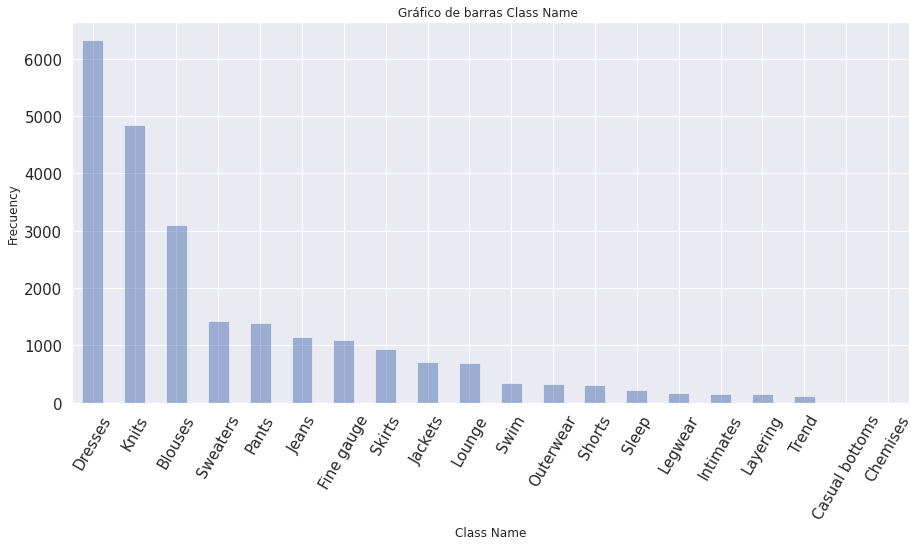

In [12]:
#No se si esta bien este grafico :C
df['Class Name'].value_counts().plot.bar(alpha=0.5,figsize = (15,7), fontsize = 15, rot = 60,
                                         title="Gráfico de barras Class Name ",
                                         xlabel="Class Name", ylabel="Frecuency")

### Preparación de las Columnas para el Entrenamiento

In [13]:
reviews_and_ratings = reviews[['Review Text', 'Rating']].copy()
reviews_and_ratings

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5
...,...,...
23481,I was very happy to snag this dress at such a ...,5
23482,"It reminds me of maternity clothes. soft, stre...",3
23483,"This fit well, but the top was very see throug...",3
23484,I bought this dress for a wedding i have this ...,3


#### Verificación nulls

In [14]:
reviews_and_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review Text  22641 non-null  object
 1   Rating       23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.1+ KB


Vemos que hay cantidades diferentes de reviews y ratings no nulos, por lo que vamos a sacar los datos inválidos.

In [15]:
reviews_and_ratings.dropna(inplace=True)
reviews_and_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review Text  22641 non-null  object
 1   Rating       22641 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 530.6+ KB


In [16]:
reviews_and_ratings

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5
...,...,...
23481,I was very happy to snag this dress at such a ...,5
23482,"It reminds me of maternity clothes. soft, stre...",3
23483,"This fit well, but the top was very see throug...",3
23484,I bought this dress for a wedding i have this ...,3


Al hacer el `dropna()`, se están salteando índices. Para arreglar esto, vamos a resetear los índices con el método `reset_index()`.

In [17]:
reviews_and_ratings.reset_index(inplace=True)
reviews_and_ratings.drop(columns=['index'], inplace=True)
reviews_and_ratings

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5
...,...,...
22636,I was very happy to snag this dress at such a ...,5
22637,"It reminds me of maternity clothes. soft, stre...",3
22638,"This fit well, but the top was very see throug...",3
22639,I bought this dress for a wedding i have this ...,3


Transformamos la variable a predecir como se pide en la consigna.

In [18]:
reviews_and_target = reviews_and_ratings.copy()
reviews_and_target['Good Ratings'] = reviews_and_target.Rating >= 4
reviews_and_target.drop(columns=['Rating'], inplace=True)
reviews_and_target

,Review Text,Good Ratings
0,Absolutely wonderful - silky and sexy and comf...,True
1,Love this dress! it's sooo pretty. i happene...,True
2,I had such high hopes for this dress and reall...,False
3,"I love, love, love this jumpsuit. it's fun, fl...",True
4,This shirt is very flattering to all due to th...,True
...,...,...
22636,I was very happy to snag this dress at such a ...,True
22637,"It reminds me of maternity clothes. soft, stre...",False
22638,"This fit well, but the top was very see throug...",False
22639,I bought this dress for a wedding i have this ...,False


### Entrenamiento con el método Regresión Logistica

Descargamos los stopwords a utilizar y el stemmer. Los stopwords los excluimos y utilizaremos un stemmer para llevar cada palabra a su raíz léxica. Definimos también un conjunto de caracteres excluidos.

In [18]:
tokenizer = ToktokTokenizer() 
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

excluded_chars = {'_'}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Para el tokenizador de abajo definimos el siguiente flujo de filtrado:
    - Filtramos con expresiones regulares valores no alfanuméricos y espacios innecesarios.
    - Luego nos quedamos con los tokens con tamaño mayor a uno.
    - Posteriormente eliminamos los stopwords y números.
    - Pasamos los tokens por un stemmer.
    - Y finalmente eliminamos las palabras que sean completamente compuestas por carácteres inválidos (en nuestro caso, necesitamos filtrar el barra baja).

In [19]:
def negate_tokens(text) -> str:
    words = [l for l in re.findall(r"[\w']+|[.,!?;]", text) if l != '']
    must_negate_prefix = False
    to_return = []
    for l in words:
        if l == 'no' or l == 'not':
            must_negate_prefix = True
        elif l in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~':
            must_negate_prefix = False
        elif must_negate_prefix:
            l = "NOT_" + l
        to_return.append(l)
    return ' '.join(to_return)

In [20]:
has_valid_chars = lambda w: not (len(set(w)) == 1 and set(w).pop() in excluded_chars)
regex_filter = lambda text: re.sub(r'\s+', ' ', re.sub(r'\W', ' ', str(text)), flags = re.I)
filter_words = lambda tokens: [token for token in tokens if token not in stop_words and not token.isdigit() and len(token) > 1]
word_stemmer = lambda tokens: [stemmer.stem(token) for token in tokens]
filter_stemd = lambda words: [w for w in words if has_valid_chars(w)]

def tokenize(text):
    clean_text = regex_filter(negate_tokens(text))
    tokens = [w for w in tokenizer.tokenize(clean_text)]
    stems = word_stemmer(tokens)
    tokens = filter_words(tokens)
    return filter_stemd(stems)

Separamos el conjunto de entrenamiento como un 70% aleatorio del set de datos mientras que el otro 30% queda para el set de testing.

In [21]:
reviews = reviews_and_target['Review Text']
ratings = reviews_and_target['Good Ratings']

X_train, X_test, y_train, y_test = train_test_split(reviews, ratings, test_size = 0.3, random_state=2)

Verificamos que las dimensiones matcheen:

In [22]:
X_train.shape, y_train.shape

((15848,), (15848,))

In [23]:
X_test.shape, y_test.shape

((6793,), (6793,))

Instanciamos el vectorizador de palabras, el cual utiliza TF-IDF.

In [24]:
tfidf = TfidfVectorizer(
    tokenizer=tokenize,
    max_features=20000)  

tfidf.fit(X_train)

C:\Users\jonat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:514: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(max_features=20000,
                tokenizer=<function tokenize at 0x00000241F82E9750>)

Vectorizamos los sets con data.

In [25]:
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

Instanciamos el `LogisticRegressor`. Entrenaremos el modelo con 10 folds (dividiendo en 10 el set de entrenamiento) y realizando validaciones cruzadas para buscar el hiperparámetro `C` más eficiente (el cuál permite evitar el overfitting).

In [26]:
parameters = {'C':[50, 10, 5, 3, 1, 0.1, 0.25, 0.01]}

lr = LogisticRegression(random_state=2, solver='liblinear')

cv = KFold(n_splits=10, shuffle=True, random_state=2)

clf = GridSearchCV(lr, parameters, 
                   scoring='accuracy',
                   cv=cv,
                   refit=True,
                   verbose=2,
                   error_score='raise',
                   n_jobs=-1)

In [27]:
clf.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=2, shuffle=True),
             error_score='raise',
             estimator=LogisticRegression(random_state=2, solver='liblinear'),
             n_jobs=-1, param_grid={'C': [50, 10, 5, 3, 1, 0.1, 0.25, 0.01]},
             scoring='accuracy', verbose=2)

In [28]:
print('Mejor combinación de parámetros: %s ' % clf.best_params_)
print('CV Accuracy: %.3f' % clf.best_score_)

Mejor combinación de parámetros: {'C': 3} 
CV Accuracy: 0.884


In [29]:
best_clf = clf.best_estimator_
print('Test Accuracy: %.3f' % best_clf.score(X_test, y_test))

Test Accuracy: 0.885


In [30]:
eli5.show_weights(estimator=best_clf, 
                  feature_names= list(tfidf.get_feature_names()),
                 top=(10, 10))

Weight?,Feature
+8.528,perfect
+5.921,flatter
+5.882,great
+5.880,compliment
+5.679,love
+5.558,comfort
+4.349,soft
+4.123,littl
+4.021,uniqu
+3.973,not_too


In [31]:
def compute_values(model, y_test, X_test):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    print(f"La precision es: {precision}")
    print(f"El recall es: {recall}")
    print(f"El f1-score es: {(2 * recall * precision) / (precision + recall)}")

In [32]:
compute_values(model = clf, y_test=y_test, X_test=X_test )

La precision es: 0.9120533234586188
El recall es: 0.9415137614678899
El f1-score es: 0.9265494216119627


### Entrenamiento con el método Regresión Logistica

In [33]:
X_train, X_test, y_train, y_test = train_test_split(reviews, ratings, test_size=0.3, random_state=45)

In [34]:
vec = CountVectorizer(stop_words='english')
X_train = vec.fit_transform(X_train).toarray()
X_test = vec.transform(X_test).toarray()

In [35]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [36]:
model.score(X_test, y_test)

0.8782570292948624

In [37]:
compute_values(model = model, y_test=y_test, X_test=X_test)

La precision es: 0.9114796869176295
El recall es: 0.932862864772077
El f1-score es: 0.9220473183146385


### Entrenamiento con el método Árbol de Decisión

In [38]:
X_train, X_test, y_train, y_test = train_test_split(reviews, ratings, test_size=0.3, random_state=45)

In [39]:
X_train = X_train.apply(lambda x:' '.join(tokenize(x)))
X_test = X_test.apply(lambda x:' '.join(tokenize(x)))

#tfidf = TfidfVectorizer(tokenizer=tokenize, max_features=20000)  

#X_train = tfidf.fit_transform(X_train).toarray()
#X_test = tfidf.transform(X_test).toarray()


vec = CountVectorizer(stop_words='english')
X_train = vec.fit_transform(X_train).toarray()
X_test = vec.transform(X_test).toarray()

In [ ]:
#tree_model = DecisionTreeClassifier(max_depth=10)
#tree_model.fit(X_train, y_train)
#parameters = {'C':[50, 10, 5, 3, 1, 0.1, 0.25, 0.01]}
tree_params = {'criterion':['gini'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
tree_model = GridSearchCV(DecisionTreeClassifier(random_state=3), tree_params, cv=5, refit=True, n_jobs=-1)
tree_model.fit(X_train, y_train)

In [ ]:
compute_values(model = tree_model, y_test=y_test, X_test=X_test)

### Entrenamiento con el método Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reviews, ratings, test_size=0.3, random_state=45)

In [ ]:
X_train = X_train.apply(lambda x:' '.join(tokenize(x)))
X_test = X_test.apply(lambda x:' '.join(tokenize(x)))

#tfidf = TfidfVectorizer(tokenizer=tokenize, max_features=20000)

#X_train = tfidf.fit_transform(X_train).toarray()
#X_test = tfidf.transform(X_test).toarray()

vec = CountVectorizer(stop_words='english')
X_train = vec.fit_transform(X_train).toarray()
X_test = vec.transform(X_test).toarray()

In [ ]:
#random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=500, random_state=3)
#random_forest_model.fit(X_train, y_train)


tree_params = {'criterion':['gini'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
random_forest_model = GridSearchCV(RandomForestClassifier(random_state=3), tree_params, cv=5, refit=True, n_jobs=-1)
random_forest_model.fit(X_train, y_train)

In [ ]:
compute_values(model = random_forest_model, y_test=y_test, X_test=X_test)